# Лабораторная работа №5. Генерация новых признаков. Скалирование данных. Устранение проблемы мультиколлинеарности.



**Содержание**<a id='toc0_'></a>    
- 1. [Раздел 1. Импорт библиотек и загрузка данных](#toc1_)
- 2. [Раздел 2. Анализ мультиколлинеарности](#toc2_)
  - 2.1 [Тепловая карта корреляций](#toc2_1_)
  - 2.2 [Устранение мультиколлинеарности](#toc2_2_)
  - 2.3 [Исследование диспропорции значений и скалирование](#toc2_3_)
  - 2.4 [PCA + метод локтя](#toc2_4_)
- 3. [Раздел 3. Сохранение результатов и вывод](#toc3_)

# 1. <a id='toc1_'></a>[Раздел 1. Импорт библиотек и загрузка данных](#toc1_)

### Цель работы  
Выполнить генерацию новых признаков, скалирование данных и устранение мультиколлинеарности для подготовки датасета к обучению моделей:
- проанализировать корреляции и устранить мультиколлинеарность с использованием формул прикладной области
- исследовать диспропорцию значений признаков
- применить три метода скалирования
- (доп. задание) применить PCA для анализа дисперсии и понижения размерности


**Формирование окружения для работы**

Первоначально необходимо подготовить окружение для работы с данными и их моделирования. Чтобы не возникало конфликтов виртуальной среды Python, зафиксируем используемые в ходе исследования версии основных библиотек и фреймворков, которые будут использоваться далее. А также пропишем последовательность команд для формирования среды.

Первоначально установим необходимые библиотеки при помощи пакетного менеджера `pip` в виртуальное окружение.

- Версия Python: 3.12.3

Сами версии можно получить с помощью команды:
`pip list --format=freeze`


| Библиотека / модуль               | Назначение                                                                 |
|-----------------------------------|-----------------------------------------------------------------------------|
| pandas                            | Работа с данными                                                            |
| numpy                             | Числовые вычисления                                                         |
| matplotlib.pyplot                 | Визуализация                                                                |
| seaborn                           | Тепловые карты                                                              |
| sklearn.preprocessing             | Скалирование данных (StandardScaler, MinMaxScaler, RobustScaler)            |
| sklearn.decomposition.PCA         | Метод главных компонент                                                     |
| warnings                          | Подавление предупреждений                                                   |

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

Для воспроизводимости результатов исследования зафиксируем основание генератора случайных чисел.

In [ ]:
SEED = 42
np.random.seed(SEED)

###  Загрузка данных из предыдущей работы

Загружаем датасет

In [ ]:
train = pd.read_csv('train_clean_final.csv')
test  = pd.read_csv('test_clean_final.csv')
print(f"train: {train.shape} | test: {test.shape}")

train: (9361, 17) | test: (2387, 17)


## 2. <a id='toc2_'></a>[Раздел 2. Анализ мультиколлинеарности](#toc2_)

## 2.1. <a id='toc2_1_'></a>[Тепловая карта корреляций](#toc2_1_)

Строим тепловую карту для анализа мультиколлинеарности в исходных данных.

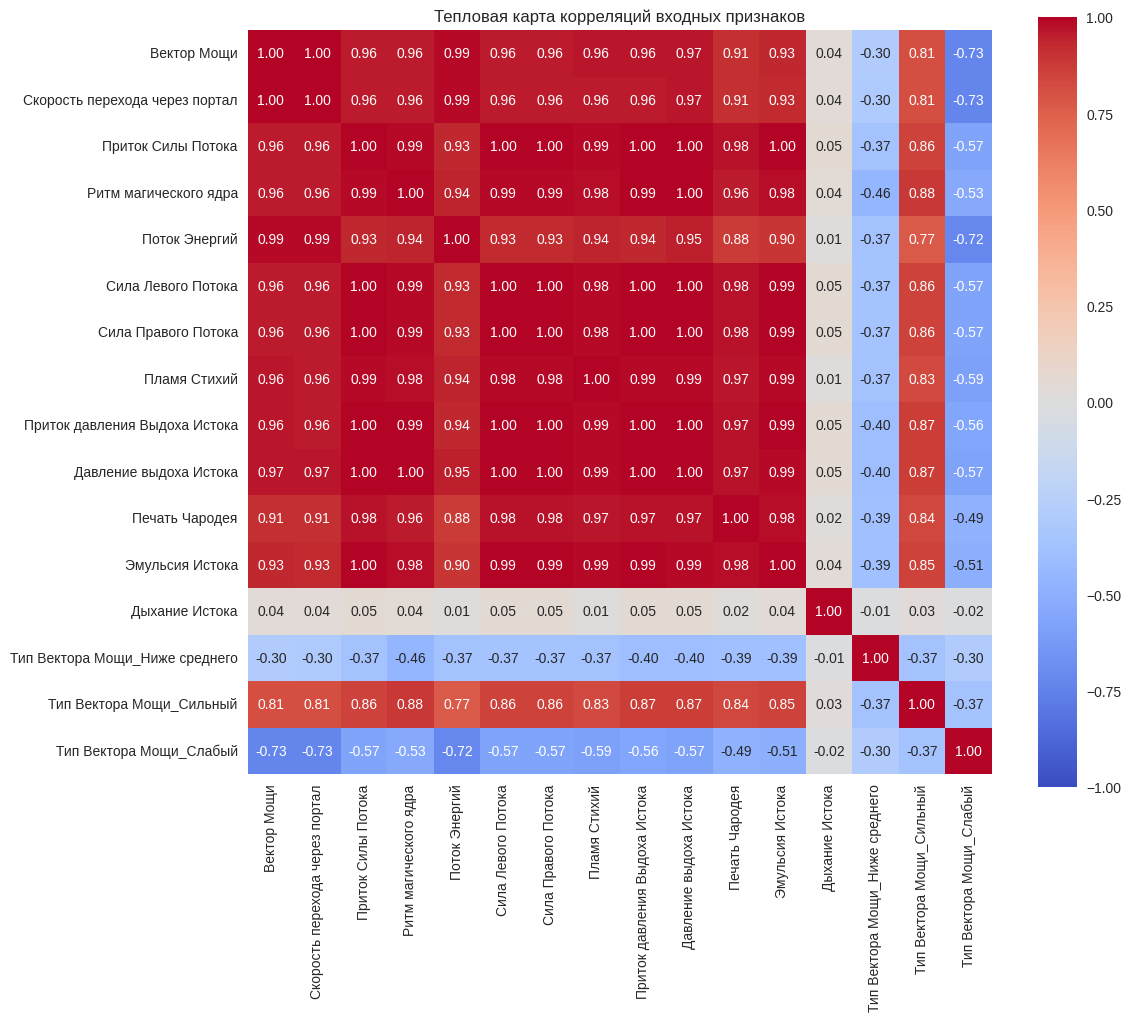

In [ ]:
corr = train.drop('Гармония Бессмертия', axis=1).corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1, square=True)
plt.title('Тепловая карта корреляций входных признаков')
plt.show()

Исходная карта показывает критическую мультиколлинеарность (>0.93) между большинством признаков.

## 2.2. <a id='toc2_2_'></a>[Устранение мультиколлинеарности](#toc2_2_)

Генерируем 5 новых признаков по формулам и удаляем все исходные коррелирующие признаки.

In [ ]:
def generate_features(df):
    df = df.copy()
    df['Общая мощность потоков'] = df['Сила Левого Потока'] + df['Сила Правого Потока']
    df['Общая сила ядра'] = df['Ритм магического ядра'] * df['Приток Силы Потока']
    df['Общее давление на выходе'] = df['Приток давления Выдоха Истока'] + df['Давление выдоха Истока']
    df['Магическая производительность'] = df['Скорость перехода через портал'] / (df['Эмульсия Истока'] + 1e-8)
    df['Эффективность ядра'] = df['Общая сила ядра'] / (df['Эмульсия Истока'] + 1e-8)

    to_drop = [
        'Вектор Мощи', 'Скорость перехода через портал', 'Приток Силы Потока',
        'Ритм магического ядра', 'Поток Энергий', 'Сила Левого Потока',
        'Сила Правого Потока', 'Пламя Стихий', 'Приток давления Выдоха Истока',
        'Давление выдоха Истока', 'Печать Чародея', 'Эмульсия Истока'
    ]
    df = df.drop(columns=[c for c in to_drop if c in df.columns])

    return df

train_feat = generate_features(train)
test_feat  = generate_features(test)
print(f"Размер после: {train_feat.shape}")

Размер после: (9361, 10)


Сгенерировано 5 новых признаков, удалено 12 исходных — размерность снижена, мультиколлинеарность устранена.

Проверка корреляций после генерации признаков.

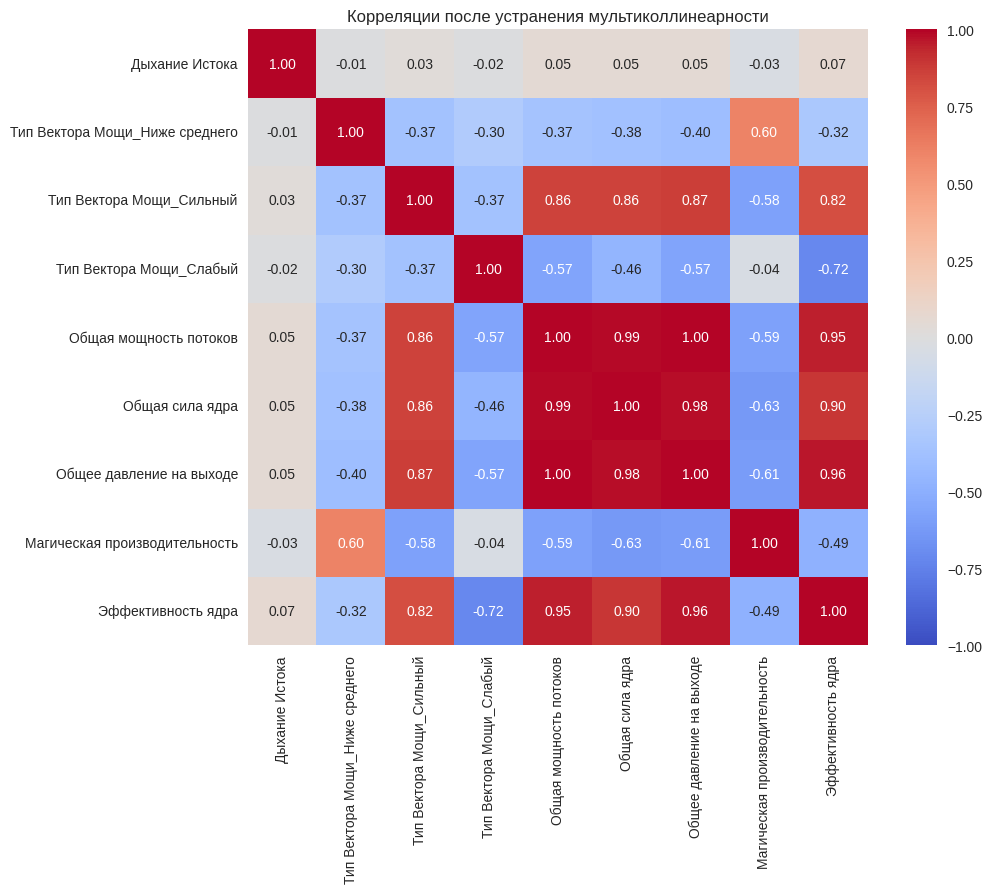

In [ ]:
corr_new = train_feat.drop('Гармония Бессмертия', axis=1).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_new, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Корреляции после устранения мультиколлинеарности')
plt.show()

Высокие корреляции остались только внутри группы новых энергетических признаков (0.90–0.99).

## 2.3. <a id='toc2_3_'></a>[Исследование диспропорции значений и скалирование](#toc2_3_)

In [ ]:
train_feat.describe()

,Дыхание Истока,Гармония Бессмертия,Тип Вектора Мощи_Ниже среднего,Тип Вектора Мощи_Сильный,Тип Вектора Мощи_Слабый,Общая мощность потоков,Общая сила ядра,Общее давление на выходе,Магическая производительность,Эффективность ядра
count,9361.000000,9361.000000,9361.000000,9361.000000,9361.000000,9361.000000,9.361000e+03,9361.000000,9361.000000,9.361000e+03
mean,0.975411,0.987657,0.226578,0.320051,0.229356,437.054839,7.472558e+06,14.381753,13.956552,8.639677e+06
std,0.014646,0.007481,0.418640,0.466521,0.420441,387.445481,8.128181e+06,6.238044,4.238770,4.363313e+06
min,0.950000,0.975000,0.000000,0.000000,0.000000,10.608000,3.556916e+04,6.924000,4.579717,4.373923e+05
25%,0.963000,0.981000,0.000000,0.000000,0.000000,120.624000,1.216266e+06,8.826000,10.463186,4.886691e+06
50%,0.976000,0.988000,0.000000,0.000000,0.000000,350.512000,4.358531e+06,13.139000,13.677873,8.733744e+06
75%,0.988000,0.994000,0.000000,1.000000,0.000000,664.616000,1.093639e+07,18.570000,17.945649,1.262834e+07
max,1.000000,1.000000,1.000000,1.000000,1.000000,1290.498000,2.714001e+07,27.691000,25.094632,1.592358e+07


- Сильный разброс масштабов: от 0–1 (бинарные и Дыхание Истока) до миллионов (Общая сила ядра, Эффективность ядра).
- Признаки `Общая сила ядра` и `Эффективность ядра` имеют наибольший разброс (особенну у `Общая сила ядра`  `std` > `mean`).
- Целевая переменная `Гармония Бессмертия` находится в очень узком диапазоне [0.975–1.0] — это нормально для коэффициента стабильности.

Поэтому скалирование необходимо

Применяем три метода скалирования: стандартизация, MinMax, робастное

In [ ]:
X_train = train_feat.drop('Гармония Бессмертия', axis=1)
X_test  = test_feat.drop('Гармония Бессмертия', axis=1)
y_train = train_feat['Гармония Бессмертия']
y_test  = test_feat['Гармония Бессмертия']

# Стандартизация
std = StandardScaler()
X_train_std = pd.DataFrame(std.fit_transform(X_train), columns=X_train.columns)
X_test_std  = pd.DataFrame(std.transform(X_test), columns=X_test.columns)

# MinMax
minmax = MinMaxScaler()
X_train_minmax = pd.DataFrame(minmax.fit_transform(X_train), columns=X_train.columns)
X_test_minmax  = pd.DataFrame(minmax.transform(X_test), columns=X_test.columns)

# Робастное
robust = RobustScaler()
X_train_robust = pd.DataFrame(robust.fit_transform(X_train), columns=X_train.columns)
X_test_robust  = pd.DataFrame(robust.transform(X_test), columns=X_test.columns)



## 2.4. <a id='toc2_4_'></a>[PCA + метод локтя](#toc2_4_)

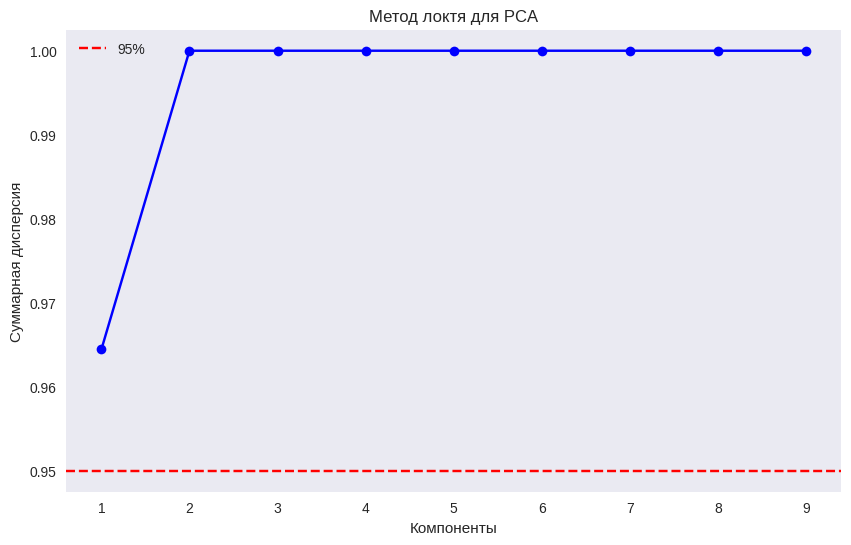

Оптимальное число компонент: 1


In [ ]:
pca = PCA()
pca.fit(X_train)

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, 'bo-')
plt.title('Метод локтя для PCA')
plt.xlabel('Компоненты')
plt.ylabel('Суммарная дисперсия')
plt.axhline(0.95, color='r', linestyle='--', label='95%')
plt.legend()
plt.grid()
plt.show()

n_comp = np.argwhere(cumulative_variance >= 0.95)[0][0] + 1
print(f"Оптимальное число компонент: {n_comp}")

pca_final = PCA(n_components=n_comp)
X_train_pca = pd.DataFrame(pca_final.fit_transform(X_train))
X_test_pca  = pd.DataFrame(pca_final.transform(X_test))


## 3. <a id='toc3_'></a>[Раздел 3. Сохранение результатов и вывод](#toc3_)

Сохраняем все версии датасетов, полученные в ЛР №5, для дальнейшего сравнения моделей:
- без скалирования
- с StandardScaler
- с MinMaxScaler
- с RobustScaler
- с PCA (5 компонент, 95% дисперсии)


In [ ]:
# Без скалирования (уже после генерации признаков)
train_feat.to_csv('train_no_scale.csv', index=False)
test_feat.to_csv('test_no_scale.csv', index=False)

# StandardScaler
pd.concat([X_train_std, y_train.reset_index(drop=True)], axis=1).to_csv('train_std.csv', index=False)
pd.concat([X_test_std, y_test.reset_index(drop=True)], axis=1).to_csv('test_std.csv', index=False)

# MinMaxScaler
pd.concat([X_train_minmax, y_train.reset_index(drop=True)], axis=1).to_csv('train_minmax.csv', index=False)
pd.concat([X_test_minmax, y_test.reset_index(drop=True)], axis=1).to_csv('test_minmax.csv', index=False)

# RobustScaler
pd.concat([X_train_robust, y_train.reset_index(drop=True)], axis=1).to_csv('train_robust.csv', index=False)
pd.concat([X_test_robust, y_test.reset_index(drop=True)], axis=1).to_csv('test_robust.csv', index=False)

# PCA (5 компонент)
X_train_pca.columns = [f'PC{i+1}' for i in range(X_train_pca.shape[1])]
X_test_pca.columns = [f'PC{i+1}' for i in range(X_test_pca.shape[1])]
pd.concat([X_train_pca, y_train.reset_index(drop=True)], axis=1).to_csv('train_pca.csv', index=False)
pd.concat([X_test_pca, y_test.reset_index(drop=True)], axis=1).to_csv('test_pca.csv', index=False)

print("Все датасеты сохранены:")
print("→ train_no_scale.csv / test_no_scale.csv")
print("→ train_std.csv / test_std.csv")
print("→ train_minmax.csv / test_minmax.csv")
print("→ train_robust.csv / test_robust.csv")
print("→ train_pca.csv / test_pca.csv")

Все датасеты сохранены:
→ train_no_scale.csv / test_no_scale.csv
→ train_std.csv / test_std.csv
→ train_minmax.csv / test_minmax.csv
→ train_robust.csv / test_robust.csv
→ train_pca.csv / test_pca.csv


### Итоговый вывод

1. **Анализ корреляций**  
   Исходная тепловая карта выявила **критическую мультиколлинеарность** (>0.93) между большинством числовых признаков.

2. **Генерация признаков и устранение мультиколлинеарности**  
   - Сгенерированы **5 новых физически осмысленных признаков** по формулам прикладной области:  
     Общая мощность потоков, Общая сила ядра, Общее давление на выходе, Магическая производительность, Эффективность ядра.  
   - Удалены все исходные сильно коррелирующие признаки (12 столбцов).  
   - Оставлены независимые признаки (Дыхание Истока и one-hot-кодировки типа вектора мощи).  
   - Финальная тепловая карта подтвердила: корреляции между признаками низкие или умеренные — **мультиколлинеарность успешно устранена**.

3. **Исследование диспропорции значений**  
   По `describe()` выявлен **сильный разброс масштабов**:  
   - от 0–1 (бинарные признаки, Дыхание Истока)  
   - до миллионов (Общая сила ядра, Эффективность ядра).  
   Скалирование необходимо.

4. **Скалирование данных**  
   Применены три метода:  
   - StandardScaler  
   - MinMaxScaler  
   - RobustScaler  

5. **Дополнительное задание: PCA**  
   - Метод локтя показал: **1 главная компонента** сохраняет **>96 %** всей дисперсии данных.  
   - Это подтверждает сильную линейную зависимость признаков после генерации — вся информация сосредоточена в одном направлении.  
   - Сформировано новое пространство с 1 компонентой (без утечки данных).

**Всего сохранено 5 пар датасетов** (без скалирования, 3 скалирования, PCA).